In [563]:
from matplotlib.pyplot import figure
import random 
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [524]:
# To Do #

# flow diagram (whimsical)
# write paragraphs explaining the problem and its significance (mention cost of outages, cost of web farm)
# Justify the validity of the model and discuss how you verified it.
# State your conclusions/ findings from the model. (mention cost of outages, cost of web farm)
# implement random seed!

# fix discrepancy between index and minutes (e.g. 1403 vs 1440) (probably just append 10 rows each downtime)
# check if logic for capacity makes sense, it's supposed to be 10,000 over 5 mins, 10,000 total

# Completed #
# capture events in dataframe
# plot dataframe
# marketing campaigns, based on week
# counter for bot attack, make it last for 5 minutes
# add randomness to -= request_queue
# create more variables in place of hardcoded values
# calculate summary statistics (total downtime, perc uptime, total outages)
# add doc strings to functions
# add colors for outages

In [552]:
RANDOM_SEED = 212

SIMULATION_MIN = 1440 * 7 # Length of simulation
QUEUE_CAP = 10000 # Queue capacity, if exceeded an outage occurs
REQS_PER_MIN = 700 # Baseline requests per minute we expect
RPM_SD = 300 # Standard deviation for requests per minute
REQS_RESP_PER_MIN = 2000 # Baseline requests the server can respond to per minute
RRPM_SD = 400 # Standard deviation for requests per minute
DOWNTIME_MIN = 10 # Downtime minutes when outage occurs

MK_START = 0 # Start of marketing campaign (zero is equivalent to midnight Monday)
MK_END = 4320 # Start of marketing campaign (zero is equivalent to 11:59 Friday)
MK_REQS_NUM = 100 # Avg. requests per minute from marketing campaign

BOT_PROB = 0.05 # Probability of bot attack
BOT_REQS_NUM = 800 # Requests per minute from bot attack
BOT_EFFECT_MIN = 5 # Length of bot attack in minutes

PR_PROB = 0.02 # Probability of press
PR_REQS_NUM = 1200 # Requests per minute from press
PR_EFFECT_MIN = 10 # Length of bot attack in minutes

In [567]:
def get_time_of_day(time_of_day_counter):
    """Determine whether it is night, morning or afternoon
    
    Params:
        time_of_day_counter - tracks what minute of the day it is currently
    Returns:
        tuple with multiplier for what time of day it is
    """
    # 8:01pm until 6am
    if time_of_day_counter > 1200 or time_of_day_counter < 301:
        time_of_day = ("Night", .9)
    # 6:01am until 12pm
    elif time_of_day_counter > 300 and time_of_day_counter < 721:
        time_of_day = ("Morning", 1)
    # 12:01pm until 8pm
    elif time_of_day_counter > 720 and time_of_day_counter < 1201:
        time_of_day = ("Afternoon", 1.3)
    return time_of_day

def get_day_of_week(day_of_week_counter):
    """Determine whether it is a weekday (Mon-Fri) or weekend (Sat-Sun)
    
    Params:
        day_of_week_counter - tracks what minute of the week it is currently
    Returns:
        tuple with multiplier for weekday or weekend
    """
    # 0 to 7200 represents minutes between Monday and Friday
    if day_of_week_counter < 7201:
        day_of_week = ("Weekday", 1)
    # Greater than 7200 represents minutes between Saturday and Sunday
    elif day_of_week_counter > 7200:
        day_of_week = ("Weekend!", 0.6)
    return day_of_week

def get_marketing_campaign(day_of_week_counter, time_of_day, mk_start, mk_end, mk_reqs_num):
    """Determine whether a marketing campaign is live
    
    Params:
        day_of_week_counter - tracks what minute of the week it is currently
        time_of_day - (str) tracks whether it is "Night", "Morning", "Afternoon"
        mk_start - start minute of the marketing campaign (e.g. 0 = Monday at midnight)
        mk_end - end minute of the marketing campaign (e.g. 4320 = Wednesday at 11:59pm)
        mk_reqs_num - static number of requests to be added to the requests per minute total
    
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if day_of_week_counter > mk_start and day_of_week_counter < mk_end and time_of_day == "Afternoon":
        mk_requests = mk_reqs_num
    else:
        mk_requests = 0
    return mk_requests

def get_attack_of_the_bots(bot_prob, bot_reqs_num):
    """Determine if a bot attack is occuring
    
    Params:
        bot_prob - probability of a bot attack occuring
        bot_reqs_num - static number of requests to be added to the requests per minute total
        
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if np.random.binomial(1, bot_prob):
        bot_requests = bot_reqs_num
    else:
        bot_requests = 0
    return bot_requests

def get_national_press(pr_prob, pr_reqs_num):
    """Determine whether the website is seeing an increase in traffic due to press
    
    Params:
        pr_prob - probability of noteworthy press occuring
        pr_reqs_num - static number of requests to be added to the requests per minute total
    Returns:
        static number of requests to be added to the requests per minute total
    """
    if np.random.binomial(1, pr_prob):
        press_requests = pr_reqs_num
    else:
        press_requests = 0
    return press_requests

def server_sim(sim_min, queue_cap, requests_per_min, rpm_sd, reqs_resp_per_min, rrpm_sd, downtime_min, 
               mk_start, mk_end, mk_reqs_num, bot_prob, bot_reqs_num, bot_effect_min, pr_prob, 
               pr_reqs_num, pr_effect_min):
    """Performs simulation of server uptime. Each loop represents one minute.
    
    Params:
        sim_min - number of minutes to simulate
        queue_cap - server capacity. if the queue exceeds this amount downtime occurs
        requests_per_min - baseline requests per minute, which is later modified by several factors
        rpm_sd - requests_per_min standard deviation
        reqs_resp_per_min - baseline requests per minute the server can respond to
        rrpm_sd - reqs_resp_per_min standard deviation
        downtime_min - when downtime occurs, this is the number of minutes to add to downtime total
        bot_effect_min - if a bot attack occurs, the number of minutes it should last
        pr_effect_min - if a press event occurs, the number of minutes it should last
    
    Returns:
        pandas dataframe capturing - Minute, Req_Queue, Downtime, Downtime_Min and more
    """
    downtime_counter = 0
    request_queue = 0
    time_of_day_counter = 1
    day_of_week_counter = 1
    pr_counter = 0
    bot_counter = 0
    i = 1
    
    df_sim = pd.DataFrame(columns = ['Minute', 'Req_Queue', 'Req_Mod', 'Time_of_Day', 
                                     'Day_of_Week', 'Req_MK', 'Req_Bots', 'Req_PR', 
                                     'Req_Orig', 'Downtime', 'Downtime_Min'])
    while i <= sim_min:
        if request_queue < 0:
            request_queue = 0
                
        time_of_day = get_time_of_day(time_of_day_counter)
        day_of_week = get_day_of_week(day_of_week_counter)
        mk_reqs = get_marketing_campaign(day_of_week_counter, time_of_day[0], mk_start, mk_end, mk_reqs_num)
        bot_reqs = get_attack_of_the_bots(bot_prob, bot_reqs_num)
        pr_reqs = get_national_press(pr_prob, pr_reqs_num)

        # If a press event has occured, initiate pr_counter with the number of minutes
        # the event should last for
        if pr_reqs > 0:
            pr_counter = pr_effect_min

        # If a press event has occured, initiate pr_reqs with the number of requests
        # that should be added to the baseline requests per minute
        if pr_counter > 0:
            pr_reqs = pr_reqs_num

        # If a bot attack has occured, initiate bot_counter with the number of minutes
        # the attack should last for
        if bot_reqs > 0:
            bot_counter = bot_effect_min

        # If a bot attack has occured, initiate bot_reqs with the number of requests
        # that should be added to the baseline requests per minute
        if bot_counter > 0:
            bot_reqs = bot_reqs_num
                
        # Generate the baseline number of requests for this minute
        avg_req_min = np.random.normal(requests_per_min, rpm_sd, 1)[0]
        
        # Modify number of requests by time of day, day of week, and other factors
        avg_req_min_mod = avg_req_min * time_of_day[1] * day_of_week[1] + mk_reqs + bot_reqs + pr_reqs
  
        # Increment request queue
        request_queue += avg_req_min_mod
        
        # Check for overcapacity and assign overcapacity variable for dataframe
        overcapacity = downtime_min if request_queue > queue_cap else 0
        
        # Append current state to dataframe
        df_sim = df_sim.append({'Minute' : i, 'Req_Queue' : request_queue, 'Req_Mod' : avg_req_min_mod,
                                'Time_of_Day' : time_of_day[0], 'Day_of_Week' : day_of_week[1], 
                                'Req_MK' : mk_reqs, 'Req_Bots' : bot_reqs, 'Req_PR' : pr_reqs, 
                                'Req_Orig' : avg_req_min, 'Downtime' : (request_queue > 10000),
                                'Downtime_Min' : overcapacity}, ignore_index = True)
         
        # 1440 is number of minutes in a day
        if time_of_day_counter == 1440:
            time_of_day_counter = 0
        
        # 10080 is number of minutes in a week
        if day_of_week_counter == 10080:
            day_of_week_counter = 0
        
        # Check for overcapacity and take appropriate actions
        if request_queue > queue_cap:
            print("DOWNTIME!")
            downtime_counter += downtime_min
            i += downtime_min
            time_of_day_counter += downtime_min
            day_of_week_counter += downtime_min
            request_queue = 0
            pr_counter = 0
            bot_counter = 0
            continue
        
        # Removing the number of requests the server was able to respond to this minute
        request_queue -= np.random.normal(reqs_resp_per_min, rrpm_sd, 1)[0]
        
        pr_counter -=1
        bot_counter -=1
        time_of_day_counter +=1
        day_of_week_counter +=1
        i += 1
        
    return df_sim


In [554]:
df_sim = server_sim(SIMULATION_MIN, QUEUE_CAP, REQS_PER_MIN, RPM_SD, REQS_RESP_PER_MIN, RRPM_SD, 
                              DOWNTIME_MIN, MK_START, MK_END, MK_REQS_NUM, BOT_PROB, BOT_REQS_NUM, BOT_EFFECT_MIN,
                              PR_PROB, PR_REQS_NUM, PR_EFFECT_MIN)


DOWNTIME!
DOWNTIME!
DOWNTIME!
DOWNTIME!


In [555]:
print("Downtime minutes: ", sum(df_sim["Downtime_Min"]))
print("Total outages: ", sum(df_sim["Downtime"]))
print("Uptime %: ", 1 - (sum(df_sim["Downtime_Min"]) / df_sim["Minute"][-1:].values[0]))

Downtime minutes:  40
Total outages:  4
Uptime %:  0.996031746031746


In [572]:
# Preview the beginning of the simulation
df_sim.head(20)

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
0,1,551.417258,551.417258,Night,1,0,0,0,612.685842,False,0
1,2,865.777128,865.777128,Night,1,0,0,0,961.974586,False,0
2,3,829.859032,829.859032,Night,1,0,0,0,922.065591,False,0
3,4,402.170012,402.170012,Night,1,0,0,0,446.855569,False,0
4,5,72.269566,72.269566,Night,1,0,0,0,80.299518,False,0
5,6,471.128141,471.128141,Night,1,0,0,0,523.475712,False,0
6,7,656.390891,656.390891,Night,1,0,0,0,729.323212,False,0
7,8,626.341443,626.341443,Night,1,0,0,0,695.934937,False,0
8,9,272.296445,272.296445,Night,1,0,0,0,302.551606,False,0
9,10,805.777106,805.777106,Night,1,0,0,0,895.307896,False,0


In [577]:
# Preview the middle of the simulation
midday = int(df_sim.shape[0] / 2)
df_sim[midday:midday+20]

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
5022,5050,1171.594259,1171.594259,Afternoon,1,0,800,0,285.841737,False,0
5023,5051,2299.403943,2299.403943,Afternoon,1,0,800,0,1153.387648,False,0
5024,5052,1971.595266,1506.299967,Afternoon,1,0,800,0,543.307667,False,0
5025,5053,1733.107884,1733.107884,Afternoon,1,0,800,0,717.775295,False,0
5026,5054,1533.940533,1533.940533,Afternoon,1,0,800,0,564.569641,False,0
5027,5055,1610.059065,1610.059065,Afternoon,1,0,800,0,623.122358,False,0
5028,5056,2168.659604,1295.473655,Afternoon,1,0,800,0,381.133581,False,0
5029,5057,2047.799498,1829.063509,Afternoon,1,0,800,0,791.587314,False,0
5030,5058,2582.543932,2410.190744,Afternoon,1,0,0,1200,930.915957,False,0
5031,5059,3791.345207,2463.399417,Afternoon,1,0,0,1200,971.845705,False,0


In [573]:
# Preview the end of the simulation
df_sim.tail(20)

,Minute,Req_Queue,Req_Mod,Time_of_Day,Day_of_Week,Req_MK,Req_Bots,Req_PR,Req_Orig,Downtime,Downtime_Min
10024,10061,711.971810,711.971810,Night,0.6,0,0,0,1318.466315,False,0
10025,10062,623.337239,623.337239,Night,0.6,0,0,0,1154.328220,False,0
10026,10063,268.108214,268.108214,Night,0.6,0,0,0,496.496693,False,0
10027,10064,519.431045,519.431045,Night,0.6,0,0,0,961.909343,False,0
10028,10065,308.466091,308.466091,Night,0.6,0,0,0,571.233502,False,0
10029,10066,467.861290,467.861290,Night,0.6,0,0,0,866.409797,False,0
10030,10067,468.476086,468.476086,Night,0.6,0,0,0,867.548307,False,0
10031,10068,195.293924,195.293924,Night,0.6,0,0,0,361.655414,False,0
10032,10069,282.486871,282.486871,Night,0.6,0,0,0,523.123835,False,0
10033,10070,371.693524,371.693524,Night,0.6,0,0,0,688.321340,False,0


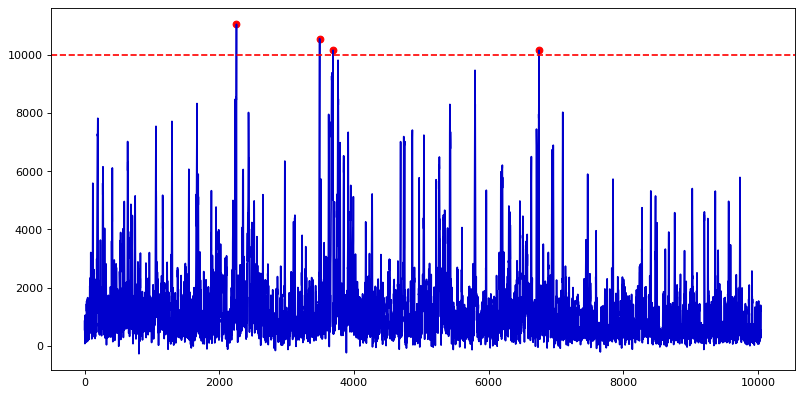

In [617]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(np.arange(len(df_sim['Req_Queue'])), df_sim['Req_Queue'], color='mediumblue')

under_thres = y < QUEUE_CAP
over_thres = np.logical_not(under_thres)

plt.axhline(QUEUE_CAP, color='red', linestyle='--')
plt.scatter(x[over_thres], y[over_thres], color='red') 

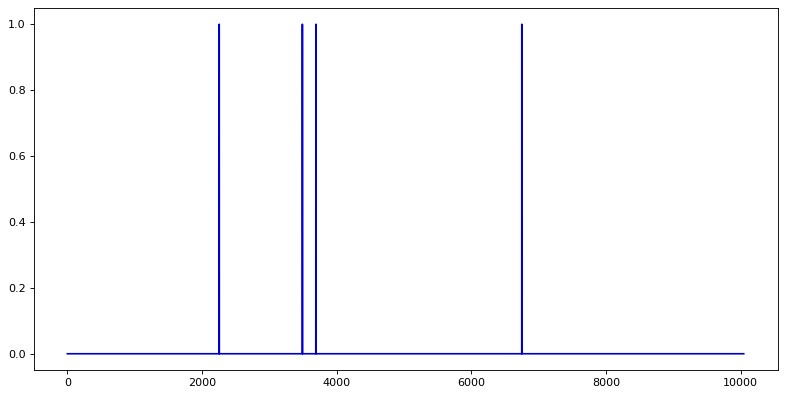

In [612]:
figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim['Downtime'], color='mediumblue')

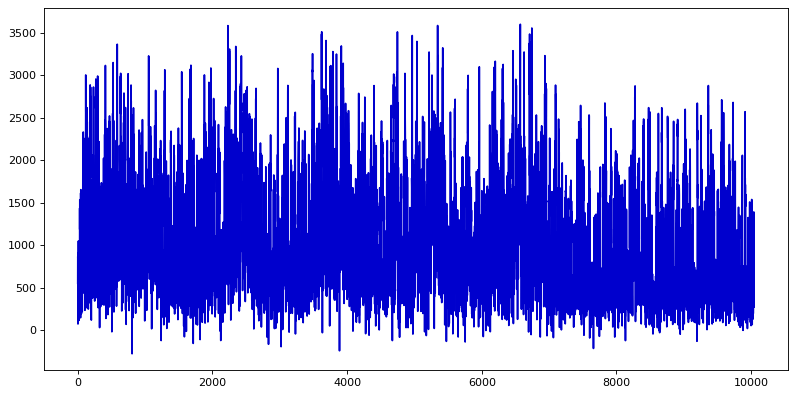

In [613]:
figure(figsize=(12, 6), dpi=80)
plt.plot(df_sim['Req_Mod'], color='mediumblue')